# LETID - Outdoor Environments 

This is an example on how to model LETID progression in outdoor environments

We can use the equations in this library to model LETID progression in a simulated outdoor environment, given that we have weather and system data. This example makes use of tools from the fabulous [pvlib](https://pvlib-python.readthedocs.io/en/stable/) library to calculate system irradiance and temperature, which we use to calculate progression in LETID states.

This will illustrate the potential of "Temporary Recovery", i.e., the backwards transition of the LETID defect B->A that can take place with carrier injection at lower temperatures.


**Requirements:**
- `pvlib`, `pandas`, `numpy`, `matplotlib`

**Objectives:**
1. Use `pvlib` and provided weather files to set up a temperature and injection timeseries
2. Define necessary solar cell device parameters
3. Define necessary degradation parameters: degraded lifetime and defect states
4. Run through timeseries, calculating defect states
5. Calculate device degradation and plot


In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.3.3

In [2]:
from pvdeg import letid, collection, utilities, DATA_DIR

import pvlib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvdeg

In [3]:
# This information helps with debugging and getting support :)
import sys
import platform

print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)
print("pvlib version ", pvlib.__version__)
print("pvdeg version ", pvdeg.__version__)

Working on a  Windows 11
Python version  3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Pandas version  2.2.3
pvlib version  0.13.0
pvdeg version  0.5.1.dev623+g51cc68b8e.d20250905


First, we'll use pvlib to create and run a model system, and use the irradiance, temperature, and operating point of that model to set up our LETID model
For this example, we'll model a fixed latitude tilt system at NREL, in Golden, CO, USA, using [NSRDB](https://nsrdb.nrel.gov/) hourly PSM weather data, SAPM temperature models, and module and inverter models from the CEC database.

In [4]:
# load weather and location data, use pvlib read_psm3 function with map_variables = True

sam_file = "psm3.csv"
weather, meta = pvdeg.weather.read(
    os.path.join(DATA_DIR, sam_file), file_type="PSM3", map_variables=True
)

In [5]:
weather

,Year,Month,Day,Hour,Minute,dni,dhi,ghi,temp_air,dew_point,wind_speed,relative_humidity,poa_global,temp_cell,temp_module
1999-01-01 00:30:00-07:00,1999,1,1,0,30,0.0,0.0,0.0,0.0,-5.0,1.8,79.39,0.0,0.0,0.0
1999-01-01 01:30:00-07:00,1999,1,1,1,30,0.0,0.0,0.0,0.0,-4.0,1.7,80.84,0.0,0.0,0.0
1999-01-01 02:30:00-07:00,1999,1,1,2,30,0.0,0.0,0.0,0.0,-4.0,1.5,82.98,0.0,0.0,0.0
1999-01-01 03:30:00-07:00,1999,1,1,3,30,0.0,0.0,0.0,0.0,-4.0,1.3,85.01,0.0,0.0,0.0
1999-01-01 04:30:00-07:00,1999,1,1,4,30,0.0,0.0,0.0,0.0,-4.0,1.3,85.81,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31 19:30:00-07:00,1999,12,31,19,30,0.0,0.0,0.0,0.0,-3.0,0.9,83.63,0.0,0.0,0.0
1999-12-31 20:30:00-07:00,1999,12,31,20,30,0.0,0.0,0.0,0.0,-3.0,1.2,86.82,0.0,0.0,0.0
1999-12-31 21:30:00-07:00,1999,12,31,21,30,0.0,0.0,0.0,0.0,-4.0,1.6,83.78,0.0,0.0,0.0
1999-12-31 22:30:00-07:00,1999,12,31,22,30,0.0,0.0,0.0,0.0,-4.0,1.7,81.22,0.0,0.0,0.0


In [6]:
# if our weather file doesn't have precipitable water, calculate it with pvlib
if "precipitable_water" not in weather.columns:
    weather["precipitable_water"] = pvlib.atmosphere.gueymard94_pw(
        weather["temp_air"], weather["relative_humidity"]
    )

In [7]:
# rename some columns for pvlib if they haven't been already
weather.rename(
    columns={
        "GHI": "ghi",
        "DNI": "dni",
        "DHI": "dhi",
        "Temperature": "temp_air",
        "Wind Speed": "wind_speed",
        "Relative Humidity": "relative_humidity",
        "Precipitable Water": "precipitable_water",
    },
    inplace=True,
)
weather = weather[
    [
        "ghi",
        "dni",
        "dhi",
        "temp_air",
        "wind_speed",
        "relative_humidity",
        "precipitable_water",
    ]
]

In [8]:
weather

,ghi,dni,dhi,temp_air,wind_speed,relative_humidity,precipitable_water
1999-01-01 00:30:00-07:00,0.0,0.0,0.0,0.0,1.8,79.39,0.891869
1999-01-01 01:30:00-07:00,0.0,0.0,0.0,0.0,1.7,80.84,0.908158
1999-01-01 02:30:00-07:00,0.0,0.0,0.0,0.0,1.5,82.98,0.932199
1999-01-01 03:30:00-07:00,0.0,0.0,0.0,0.0,1.3,85.01,0.955004
1999-01-01 04:30:00-07:00,0.0,0.0,0.0,0.0,1.3,85.81,0.963991
...,...,...,...,...,...,...,...
1999-12-31 19:30:00-07:00,0.0,0.0,0.0,0.0,0.9,83.63,0.939501
1999-12-31 20:30:00-07:00,0.0,0.0,0.0,0.0,1.2,86.82,0.975338
1999-12-31 21:30:00-07:00,0.0,0.0,0.0,0.0,1.6,83.78,0.941186
1999-12-31 22:30:00-07:00,0.0,0.0,0.0,0.0,1.7,81.22,0.912427


In [9]:
# import pvlib stuff and pick a module and inverter. Choice of these things will slightly affect the pvlib results which we later use to calculate injection.
# we'll use the SAPM temperature model open-rack glass/polymer coeffecients.

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain

cec_modules = pvlib.pvsystem.retrieve_sam("CECMod")
cec_inverters = pvlib.pvsystem.retrieve_sam("cecinverter")

cec_module = cec_modules["Jinko_Solar_Co___Ltd_JKM260P_60"]
cec_inverter = cec_inverters["ABB__ULTRA_750_TL_OUTD_1_US_690_x_y_z__690V_"]

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS["sapm"][
    "open_rack_glass_polymer"
]

In [10]:
# set up system in pvlib
lat = meta["latitude"]
lon = meta["longitude"]
tz = meta["tz"]
elevation = meta["altitude"]
surface_tilt = lat  # fixed, latitude tilt
surface_azimuth = 180  # south-facing

location = Location(lat, lon, tz, elevation, "Golden, CO, USA")

system = PVSystem(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    module_parameters=cec_module,
    inverter_parameters=cec_inverter,
    temperature_model_parameters=temperature_model_parameters,
)

In [11]:
# create and run pvlib modelchain
mc = ModelChain(system, location, aoi_model="physical")
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: no_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## Set up timeseries
In this example, injection is a function of both the operating point of the module (which we will assume is maximum power point) and irradiance. Maximum power point injection is equivalent to $(I_{sc}-I_{mp})/I_{sc}\times Ee$, where $Ee$ is effective irradiance, the irradiance absorbed by the module's cells. We normalize it to 1-sun irradiance, 1000 $W/m^2$.

We will use the irradiance, DC operating point, and cell temperature from the pvlib modelchain results.

In [12]:
ee = mc.results.effective_irradiance
# injection = (mc.results.dc['i_sc']-mc.results.dc['i_mp'])/(mc.results.dc['i_sc'])*(ee/1000)
injection = letid.calc_injection_outdoors(mc.results)
temperature = mc.results.cell_temperature

timesteps = pd.DataFrame(
    {"Temperature": temperature, "Injection": injection}
)  # create a DataFrame with cell temperature and injection
timesteps.reset_index(
    inplace=True
)  # reset the index so datetime is a column. I prefer integer indexing.
timesteps.rename(columns={"index": "Datetime"}, inplace=True)

In [13]:
# filter out times when injection is NaN, these won't progress LETID, and it'll make the calculations below run faster
timesteps = timesteps[timesteps["Injection"].notnull()]
timesteps.reset_index(inplace=True, drop=True)

In [14]:
timesteps

,Datetime,Temperature,Injection
0,1999-01-01 08:30:00-07:00,3.348774,0.006094
1,1999-01-01 09:30:00-07:00,12.378439,0.031193
2,1999-01-01 10:30:00-07:00,16.595081,0.044058
3,1999-01-01 11:30:00-07:00,17.457240,0.043239
4,1999-01-01 12:30:00-07:00,6.392783,0.007145
...,...,...,...
4296,1999-12-31 12:30:00-07:00,9.515577,0.001159
4297,1999-12-31 13:30:00-07:00,28.119796,0.044562
4298,1999-12-31 14:30:00-07:00,23.314672,0.034774
4299,1999-12-31 15:30:00-07:00,17.890528,0.027285


## Device parameters
To define a device, we need to define several important quantities about the device: wafer thickness (in $\mu m$), rear surface recombination velocity (in cm/s), and cell area (in cm<sup>2</sup>).

In [15]:
wafer_thickness = 180  # um
s_rear = 46  # cm/s
cell_area = 243  # cm^2

 <b> Other device parameters </b>
Other required device parameters: base diffusivity (in cm<sup>2</sup>/s), and optical generation profile, which allow us to estimate current collection in the device.

In [16]:
generation_df = pd.read_excel(
    os.path.join(DATA_DIR, "PVL_GenProfile.xlsx"), header=0
)  # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df["Generation (cm-3s-1)"]
depth = generation_df["Depth (um)"]

d_base = 27  # cm^2/s electron diffusivity. See https://www2.pvlighthouse.com.au/calculators/mobility%20calculator/mobility%20calculator.aspx for details

## Degradation parameters
To model the device's degradation, we need to define several more important quantities about the degradation the device will experience. These include undegraded and degraded lifetime (in $\mu s$).

In [17]:
tau_0 = 115  # us, carrier lifetime in non-degraded states, e.g. LETID/LID states A or C
tau_deg = 55  # us, carrier lifetime in fully-degraded state, e.g. LETID/LID state B

<b>Remaining degradation parameters: </b>

The rest of the quantities to define are: the initial percentage of defects in each state (A, B, and C), and the dictionary of mechanism parameters.

In this example, we'll assume the device starts in the fully-undegraded state (100% state A), and we'll use the kinetic parameters for LETID degradation from Repins.

In [18]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

mechanism_params = utilities.get_kinetics("repins")

timesteps[["NA", "NB", "NC", "tau"]] = (
    np.nan
)  # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ["NA", "NB", "NC"]] = (
    nA_0,
    nB_0,
    nC_0,
)  # assign first timestep defect state percentages
timesteps.loc[0, "tau"] = letid.tau_now(
    tau_0, tau_deg, nB_0
)  # calculate tau for the first timestep

## Run through timesteps
Since each timestep depends on the preceding timestep, we need to calculate in a loop. This will take a few minutes depending on the length of the timeseries.

In [19]:
for index, timestep in timesteps.iterrows():
    # first row tau has already been assigned
    if index == 0:
        # calc device parameters for first row
        tau = tau_0
        jsc = collection.calculate_jsc_from_tau_cp(
            tau, wafer_thickness, d_base, s_rear, generation, depth
        )
        voc = letid.calc_voc_from_tau(tau, wafer_thickness, s_rear, jsc, temperature=25)
        timesteps.at[index, "Jsc"] = jsc
        timesteps.at[index, "Voc"] = voc

    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index - 1, "NA"]
        n_B = timesteps.at[index - 1, "NB"]
        n_C = timesteps.at[index - 1, "NC"]

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        jsc = collection.calculate_jsc_from_tau_cp(
            tau, wafer_thickness, d_base, s_rear, generation, depth
        )

        temperature = timesteps.at[index, "Temperature"]
        injection = timesteps.at[index, "Injection"]

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(
            mechanism_params["v_ab"], mechanism_params["ea_ab"], temperature
        )
        k_BA = letid.k_ij(
            mechanism_params["v_ba"], mechanism_params["ea_ba"], temperature
        )
        k_BC = letid.k_ij(
            mechanism_params["v_bc"], mechanism_params["ea_bc"], temperature
        )
        k_CB = letid.k_ij(
            mechanism_params["v_cb"], mechanism_params["ea_cb"], temperature
        )

        x_ab = letid.carrier_factor(
            tau,
            "ab",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )
        x_ba = letid.carrier_factor(
            tau,
            "ba",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )
        x_bc = letid.carrier_factor(
            tau,
            "bc",
            temperature,
            injection,
            jsc,
            wafer_thickness,
            s_rear,
            mechanism_params,
        )

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (
            (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        )
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (
            timesteps.at[index, "Datetime"] - timesteps.at[index - 1, "Datetime"]
        ).total_seconds()

        # assign new defect state percentages
        timesteps.at[index, "NA"] = n_A + dN_Adt * t_step
        timesteps.at[index, "NB"] = n_B + dN_Bdt * t_step
        timesteps.at[index, "NC"] = n_C + dN_Cdt * t_step

        # calculate device parameters
        timesteps.at[index, "tau"] = tau
        timesteps.at[index, "Jsc"] = jsc
        timesteps.at[index, "Voc"] = letid.calc_voc_from_tau(
            tau, wafer_thickness, s_rear, jsc, temperature=25
        )

## Finish calculating degraded device parameters.
Now that we have calculated defect states, we can calculate all the quantities that depend on defect states.

In [20]:
timesteps["tau"] = letid.tau_now(tau_0, tau_deg, timesteps["NB"])

# calculate device Jsc for every timestep. Unfortunately this requires an integration so I think we have to run through a loop. Device Jsc allows calculation of device Voc.
for index, timestep in timesteps.iterrows():
    jsc_now = collection.calculate_jsc_from_tau_cp(
        timesteps.at[index, "tau"], wafer_thickness, d_base, s_rear, generation, depth
    )
    timesteps.at[index, "Jsc"] = jsc_now
    timesteps.at[index, "Voc"] = letid.calc_voc_from_tau(
        timesteps.at[index, "tau"], wafer_thickness, s_rear, jsc_now, temperature=25
    )

In [21]:
timesteps = letid.calc_device_params(
    timesteps, cell_area=243
)  # this function quickly calculates the rest of the device parameters: Isc, FF, max power, and normalized max power

timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
0,1999-01-01 08:30:00-07:00,3.348774,0.006094,100.000000,0.000000,0.000000e+00,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1,1999-01-01 09:30:00-07:00,12.378439,0.031193,99.997579,0.002421,0.000000e+00,114.996963,41.590987,0.666327,10.106610,0.840987,5.663460,0.999999
2,1999-01-01 10:30:00-07:00,16.595081,0.044058,99.992005,0.007995,5.966711e-09,114.989971,41.590966,0.666326,10.106605,0.840986,5.663446,0.999996
3,1999-01-01 11:30:00-07:00,17.457240,0.043239,99.985976,0.014024,2.732911e-08,114.982409,41.590942,0.666324,10.106599,0.840986,5.663430,0.999994
4,1999-01-01 12:30:00-07:00,6.392783,0.007145,99.985711,0.014289,2.841966e-08,114.982076,41.590941,0.666324,10.106599,0.840986,5.663430,0.999993
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,1999-12-31 12:30:00-07:00,9.515577,0.001159,41.396088,54.267061,4.336851e+00,72.235986,41.384030,0.656856,10.056319,0.839304,5.544072,0.978918
4297,1999-12-31 13:30:00-07:00,28.119796,0.044562,41.396882,54.265942,4.337177e+00,72.236540,41.384034,0.656856,10.056320,0.839304,5.544074,0.978919
4298,1999-12-31 14:30:00-07:00,23.314672,0.034774,41.402923,54.259760,4.337317e+00,72.239600,41.384057,0.656857,10.056326,0.839305,5.544086,0.978921
4299,1999-12-31 15:30:00-07:00,17.890528,0.027285,41.415085,54.247542,4.337373e+00,72.245649,41.384102,0.656859,10.056337,0.839305,5.544109,0.978925


Note of course that all these calculated device parameters are modeled STC device parameters, not the instantaneous, weather-dependent values. This isn't a robust performance model of a degraded module.

## Plot the results

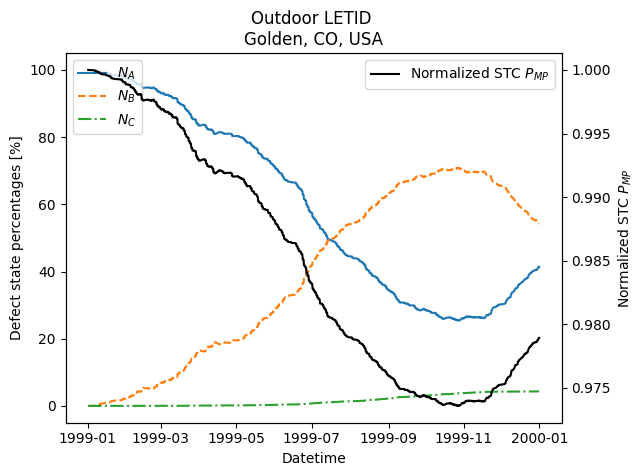

In [22]:
from cycler import cycler

plt.style.use("default")

fig, ax = plt.subplots()

ax.set_prop_cycle(
    cycler("color", ["tab:blue", "tab:orange", "tab:green"])
    + cycler("linestyle", ["-", "--", "-."])
)

ax.plot(timesteps["Datetime"], timesteps[["NA", "NB", "NC"]].values)
ax.legend(labels=["$N_A$", "$N_B$", "$N_C$"], loc="upper left")
ax.set_ylabel("Defect state percentages [%]")
ax.set_xlabel("Datetime")

ax2 = ax.twinx()
ax2.plot(
    timesteps["Datetime"],
    timesteps["Pmp_norm"],
    c="black",
    label="Normalized STC $P_{MP}$",
)
ax2.legend(loc="upper right")
ax2.set_ylabel("Normalized STC $P_{MP}$")

ax.set_title(f"Outdoor LETID \n{location.name}")

plt.show()

The example data provided for Golden, CO, shows how $N_A$ increases in cold weather, and power temporarily recovers, due to temporary recovery of LETID (B->A).

##### The function `calc_letid_outdoors` wraps all of the steps above into a single function:

In [23]:
nA_0 = 100
nB_0 = 0
nC_0 = 0
mechanism_params = "repins"

letid.calc_letid_outdoors(
    tau_0,
    tau_deg,
    wafer_thickness,
    s_rear,
    nA_0,
    nB_0,
    nC_0,
    weather,
    meta,
    mechanism_params,
    generation_df,
    module_parameters=cec_module,
)

,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
time,,,,,,,,,,,,
1999-01-01 00:30:00-07:00,0.0,NaN,100.000000,0.000000e+00,0.000000e+00,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 01:30:00-07:00,0.0,NaN,100.000000,1.702422e-15,0.000000e+00,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 02:30:00-07:00,0.0,NaN,100.000000,3.404843e-15,5.403329e-36,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 03:30:00-07:00,0.0,NaN,100.000000,5.107265e-15,1.620999e-35,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
1999-01-01 04:30:00-07:00,0.0,NaN,100.000000,6.809686e-15,3.241997e-35,115.000000,41.590997,0.666327,10.106612,0.840987,5.663467,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31 19:30:00-07:00,0.0,NaN,27.833654,6.778463e+01,4.381716e+00,66.112141,41.333851,0.654974,10.044126,0.838966,5.519257,0.974537
1999-12-31 20:30:00-07:00,0.0,NaN,27.833654,6.778463e+01,4.381716e+00,66.112141,41.333851,0.654974,10.044126,0.838966,5.519257,0.974537
1999-12-31 21:30:00-07:00,0.0,NaN,27.833654,6.778463e+01,4.381716e+00,66.112141,41.333851,0.654974,10.044126,0.838966,5.519257,0.974537
